[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mettinger/activeInference/blob/main/python/basicPerception.ipynb)

*Note*: When running this notebook in Google Colab, you probably have to run `!pip install pyro-ppl`. The cell below is commented out in case you are running this notebook locally with Pyro already installed.  For use on Colab uncomment the cell and run the cell.  After Colab installs Pyro, you may need to restart the Colab runtime.

In [ ]:
# ! pip3 install pyro-ppl 

In [1]:
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
import pyro.distributions as dist
import pyro.infer.autoguide as autoguide
import numpy as np

from IPython.display import Image

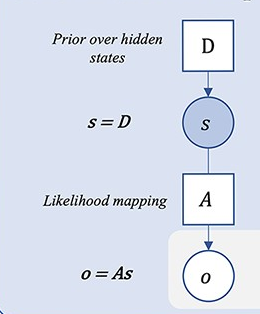

In [2]:
#Image(filename='./images/basicPerception.jpeg') 
Image(filename='../images/perception.png')

### Specify the true data generation process

In [3]:
numStates = 6
numOutcomes = 6
numObservations = 10
trueDistribution = torch.tensor([1.,0.,0.,0.,0.,0.])

assert(sum(trueDistribution) == 1)

# set the seed for reproducibility
seed = 18
torch.manual_seed(seed)

#likelihoodMatrix = torch.rand(6,6)
epsilon = .1
likelihoodMatrix = (torch.eye(6) - (epsilon * torch.eye(6))) + ((torch.ones(6) - torch.eye(6)) * (epsilon/5))

observationDistribution = torch.matmul(likelihoodMatrix, trueDistribution)

observations = torch.tensor(np.random.choice(numOutcomes, size=numObservations, replace=True, p=observationDistribution.numpy()))
print("Observations: ")
print(observations)

Observations: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)


### Define various models and guides.  "Guide" is the Pyro terminology for the variational distribution which approximates the true posterior

In [4]:
# clear the param store in case we're in a REPL
pyro.clear_param_store()

def modelAccurate(data):
    categorical = pyro.sample("categorical", dist.Categorical(1./6 * torch.ones(6)), infer={"enumerate": "parallel"})
    
    # loop over the observed data
    for i in range(len(data)):
        pyro.sample("obs_{}".format(i), 
                    dist.Categorical(likelihoodMatrix[categorical,:]), 
                    obs=data[i])

def guideAccurate(data):
    
    p = pyro.param("p", lambda: 1/6 * torch.ones(6), constraint=constraints.simplex)
    pyro.sample("categorical", dist.Categorical(p), infer={"enumerate": "parallel"})
                

In [5]:
model = modelAccurate
guide = guideAccurate
#guide = autoguide.AutoDiscreteParallel(model)

# setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO())

n_steps = 1000
# do gradient steps
for step in range(n_steps):
    loss = svi.step(observations)
    if step % 100 == 0:
        print("[step %04d] loss: %.4f" % (step, loss / len(observations)))
        
print()
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

[step 0000] loss: 3.2776
[step 0100] loss: 1.5209
[step 0200] loss: 0.6380
[step 0300] loss: 0.4510
[step 0400] loss: 0.3847
[step 0500] loss: 0.3527
[step 0600] loss: 0.3345
[step 0700] loss: 0.3230
[step 0800] loss: 0.3152
[step 0900] loss: 0.3096

p tensor([0.9931, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014],
       grad_fn=<DivBackward0>)
